In [1]:
import collections
from importlib import reload
from pathlib import Path

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import torch
import valuation
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")

reload(valuation)

<module 'valuation' from '/u/luchar/data-valuation/valuation.py'>

In [2]:
datasets = [
    v["python_class"]
    for k, v in medmnist.INFO.items()
    if not k.endswith("3d") and not k.startswith("organ")
]
imgs = {
    d: getattr(medmnist, d)(split="train", root="../data").imgs[1] for d in datasets
}

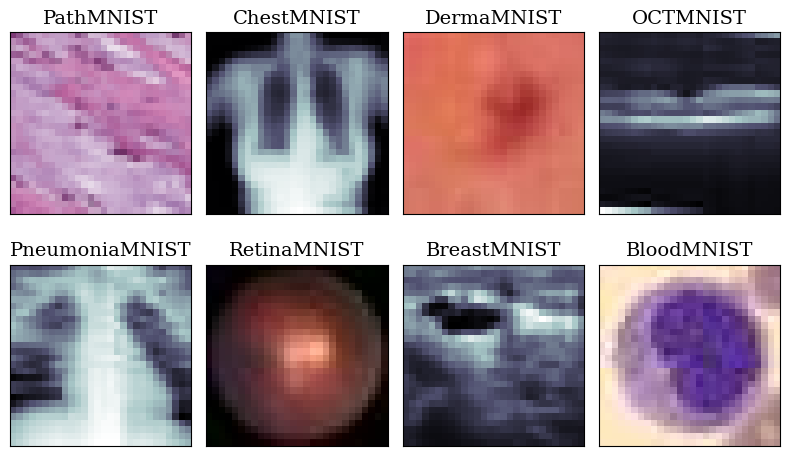

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=len(imgs) // 2, figsize=(8, 5))
for ax, (k, v) in zip(axes.flatten(), imgs.items()):
    ax.set_title(k, fontsize=14)
    if v.ndim == 2:
        cmap = "bone"
    else:
        cmap = None
    ax.imshow(v, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig(fig_dir / "medmnist.png")
plt.show()

#### Skip this if using precomputed embeddings

In [4]:
saved_embedding_path = Path("embeddings")
compute_embedding = False

if compute_embedding:
    assert torch.cuda.is_available()
    model, preprocess = clip.load("ViT-B/16", device="cuda")
    model.eval()
    make_loader = lambda ds, batch_size=16: torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
    )

    split = "train"
    dataloaders = {
        d: make_loader(
            getattr(medmnist, d)(
                split=split, transform=preprocess, download=True, root=Path("../data")
            )
        )
        for d in datasets
    }

    for k, v in dataloaders.items():
        emb = []
        # img = []
        lab = []
        for i, l in tqdm(v):
            e = model.encode_image(i.cuda()).detach().cpu()
            emb.append(e)
            # img.append(i.detach().cpu())
            lab.append(l)
        x_emb = torch.cat(emb)
        # x_img = torch.cat(img)
        x_lab = torch.cat(lab)
        torch.save(
            {
                "embeddings": x_emb,
                # 'images': x_img,
                "labels": x_lab,
            },
            saved_embedding_path / f"clip_embedding_medmnist_{k}.pt",
        )

In [5]:
#### load embedded data

In [90]:
datasets = {
    "blood": torch.load("embeddings/clip_embedding_medmnist_BloodMNIST.pt"),
    "chest": torch.load("embeddings/clip_embedding_medmnist_ChestMNIST.pt"),
    "pneum": torch.load("embeddings/clip_embedding_medmnist_PneumoniaMNIST.pt"),
    "derma": torch.load("embeddings/clip_embedding_medmnist_DermaMNIST.pt"),
    "breast": torch.load("embeddings/clip_embedding_medmnist_BreastMNIST.pt"),
    "path": torch.load("embeddings/clip_embedding_medmnist_PathMNIST.pt"),
    "oct": torch.load("embeddings/clip_embedding_medmnist_OCTMNIST.pt"),
    # "tissue": torch.load("embeddings/clip_embedding_medmnist_TissueMNIST.pt"),
    "retina": torch.load("embeddings/clip_embedding_medmnist_RetinaMNIST.pt"),
}
medmnist_tensor = []
for j in range(500):
    for ds in datasets.values():
        medmnist_tensor.append(ds["embeddings"][j])

datasets["medmnist"] = {"embeddings": torch.stack(medmnist_tensor)}

cifar = torch.load("embeddings/clip_embedding_cifar_seller.pt")
fashion = torch.load("embeddings/clip_embedding_fashion_seller.pt")
mnist = torch.load("embeddings/clip_embedding_mnist_seller.pt")

datasets["cifar"] = {'embeddings': cifar['images'], 'labels': cifar['labels']}
datasets["fashion"] = {'embeddings': fashion['images'], 'labels': fashion['labels']}
datasets["mnist"] = {'embeddings': mnist['images'], 'labels': mnist['labels']}

### Determine number of components to use

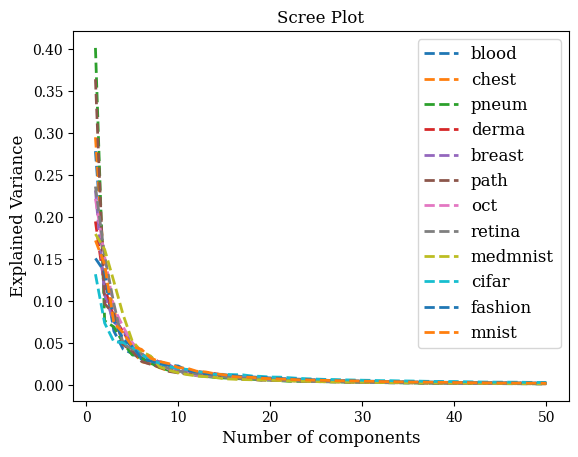

In [91]:
buyer_pca = PCA(n_components=50, svd_solver="randomized", whiten=False)

for k, v in datasets.items():
    buyer_pca.fit(v['embeddings'][:1000])
    
    # make scree plot
    PC_values = np.arange(buyer_pca.n_components_) + 1
    plt.plot(PC_values, buyer_pca.explained_variance_ratio_, "--", linewidth=2, label=k)
plt.title("Scree Plot", fontsize='large')
plt.xlabel("Number of components", fontsize='large')
plt.ylabel("Explained Variance", fontsize='large')
plt.legend(fontsize='large')
plt.show()

### Measure intrinsic diversity

In [92]:
Norm = Normalizer(norm="l2")
RJ = random_projection.GaussianRandomProjection(n_components=15)

K = lambda a, b: np.exp(-np.linalg.norm(a - b))

div_vol = {}
div_ven_cov = {}
div_ven_rbf = {}
div_std = {}


for k, v in datasets.items():
    v = v.get("embeddings", v.get("images"))
    X = v[:1000].double().numpy()
    X = Norm.fit_transform(X)
    X = RJ.fit_transform(X)
    print(k)
    vol = np.linalg.slogdet(np.dot(X.T, X))
    div_vol[k] = np.abs(vol.sign * vol.logabsdet)
    div_ven_cov[k] = vendi.score_dual(X)
    div_ven_rbf[k] = vendi.score(X, K)
    div_std[k] = np.prod(np.std(X, 0)) ** (1 / X.shape[1])

blood
chest
pneum
derma
breast
path
oct
retina
medmnist
cifar
fashion
mnist


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


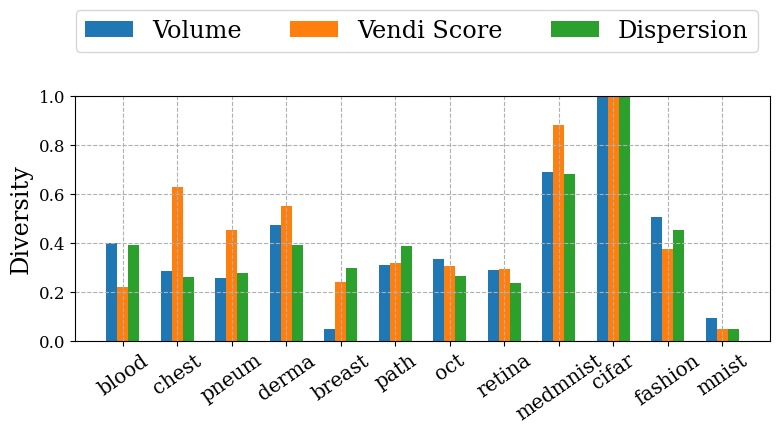

In [93]:
MMS = (
    lambda x: MinMaxScaler(feature_range=(0.05, 1))
    .fit_transform(np.array(list(x)).reshape(-1, 1))
    .flatten()
)

# Define the groups and their values
# groups = ["Volume", "Vendi Score (covariance)", "Vendi Score (RBF kernel)", "Dispersion"]
groups = ["Volume", "Vendi Score", "Dispersion"]
categories = div_vol.keys()
values = [
    MMS(div_vol.values()),
    MMS(div_ven_cov.values()),
    # MMS(div_ven_rbf.values()),
    MMS(div_std.values()),
]

# Calculate the width of each bar
bar_width = 0.20
index = np.arange(len(categories))

plt.figure(figsize=(8, 5))

# Create grouped bar chart
for i, group in enumerate(groups):
    plt.bar(index + i * bar_width, values[i], bar_width, label=group)

# Customize labels and title
# plt.xlabel('Datasets', fontsize='xx-large')
plt.ylabel("Diversity", fontsize="xx-large")
# plt.title('Grouped Bar Chart')
plt.xticks(
    index + bar_width * (len(groups) - 1) / 2,
    categories,
    rotation=35,
    fontsize="x-large",
)
plt.yticks(fontsize="large")
plt.legend(fontsize="xx-large", ncols=3, bbox_to_anchor=(1.00, 1.4))
plt.grid(ls="--")
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(fig_dir / "diversity.eps")
# Show the plot
plt.show()

### Measure relative relevance

In [116]:
# buyer_name = 'blood'
buyer_name = 'chest'
# buyer_name = 'pneum'
# buyer_name = 'derma'
# buyer_name = 'breast'
# buyer_name = 'oct'
# buyer_name = 'retina'
buyer = datasets[buyer_name]
# dataset = blood
# dataset = oct
# dataset = derma


num_buyer = 100
num_seller = 1000

buyer_data = buyer["embeddings"][-num_buyer:]

sellers = {}

sellers[buyer_name] = datasets[buyer_name]["embeddings"][:num_seller]
sellers["MedMNIST"] = datasets['medmnist']["embeddings"][:num_seller]
sellers["MNIST"] = datasets['mnist']["embeddings"][:num_seller]
sellers["Fashion"] = datasets['fashion']["embeddings"][:num_seller]
sellers["CIFAR"] = datasets['cifar']["embeddings"][:num_seller]

In [117]:
seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        norm_volume=True,
    )
    for k, v in tqdm(sellers.items())
}

  0%|          | 0/5 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


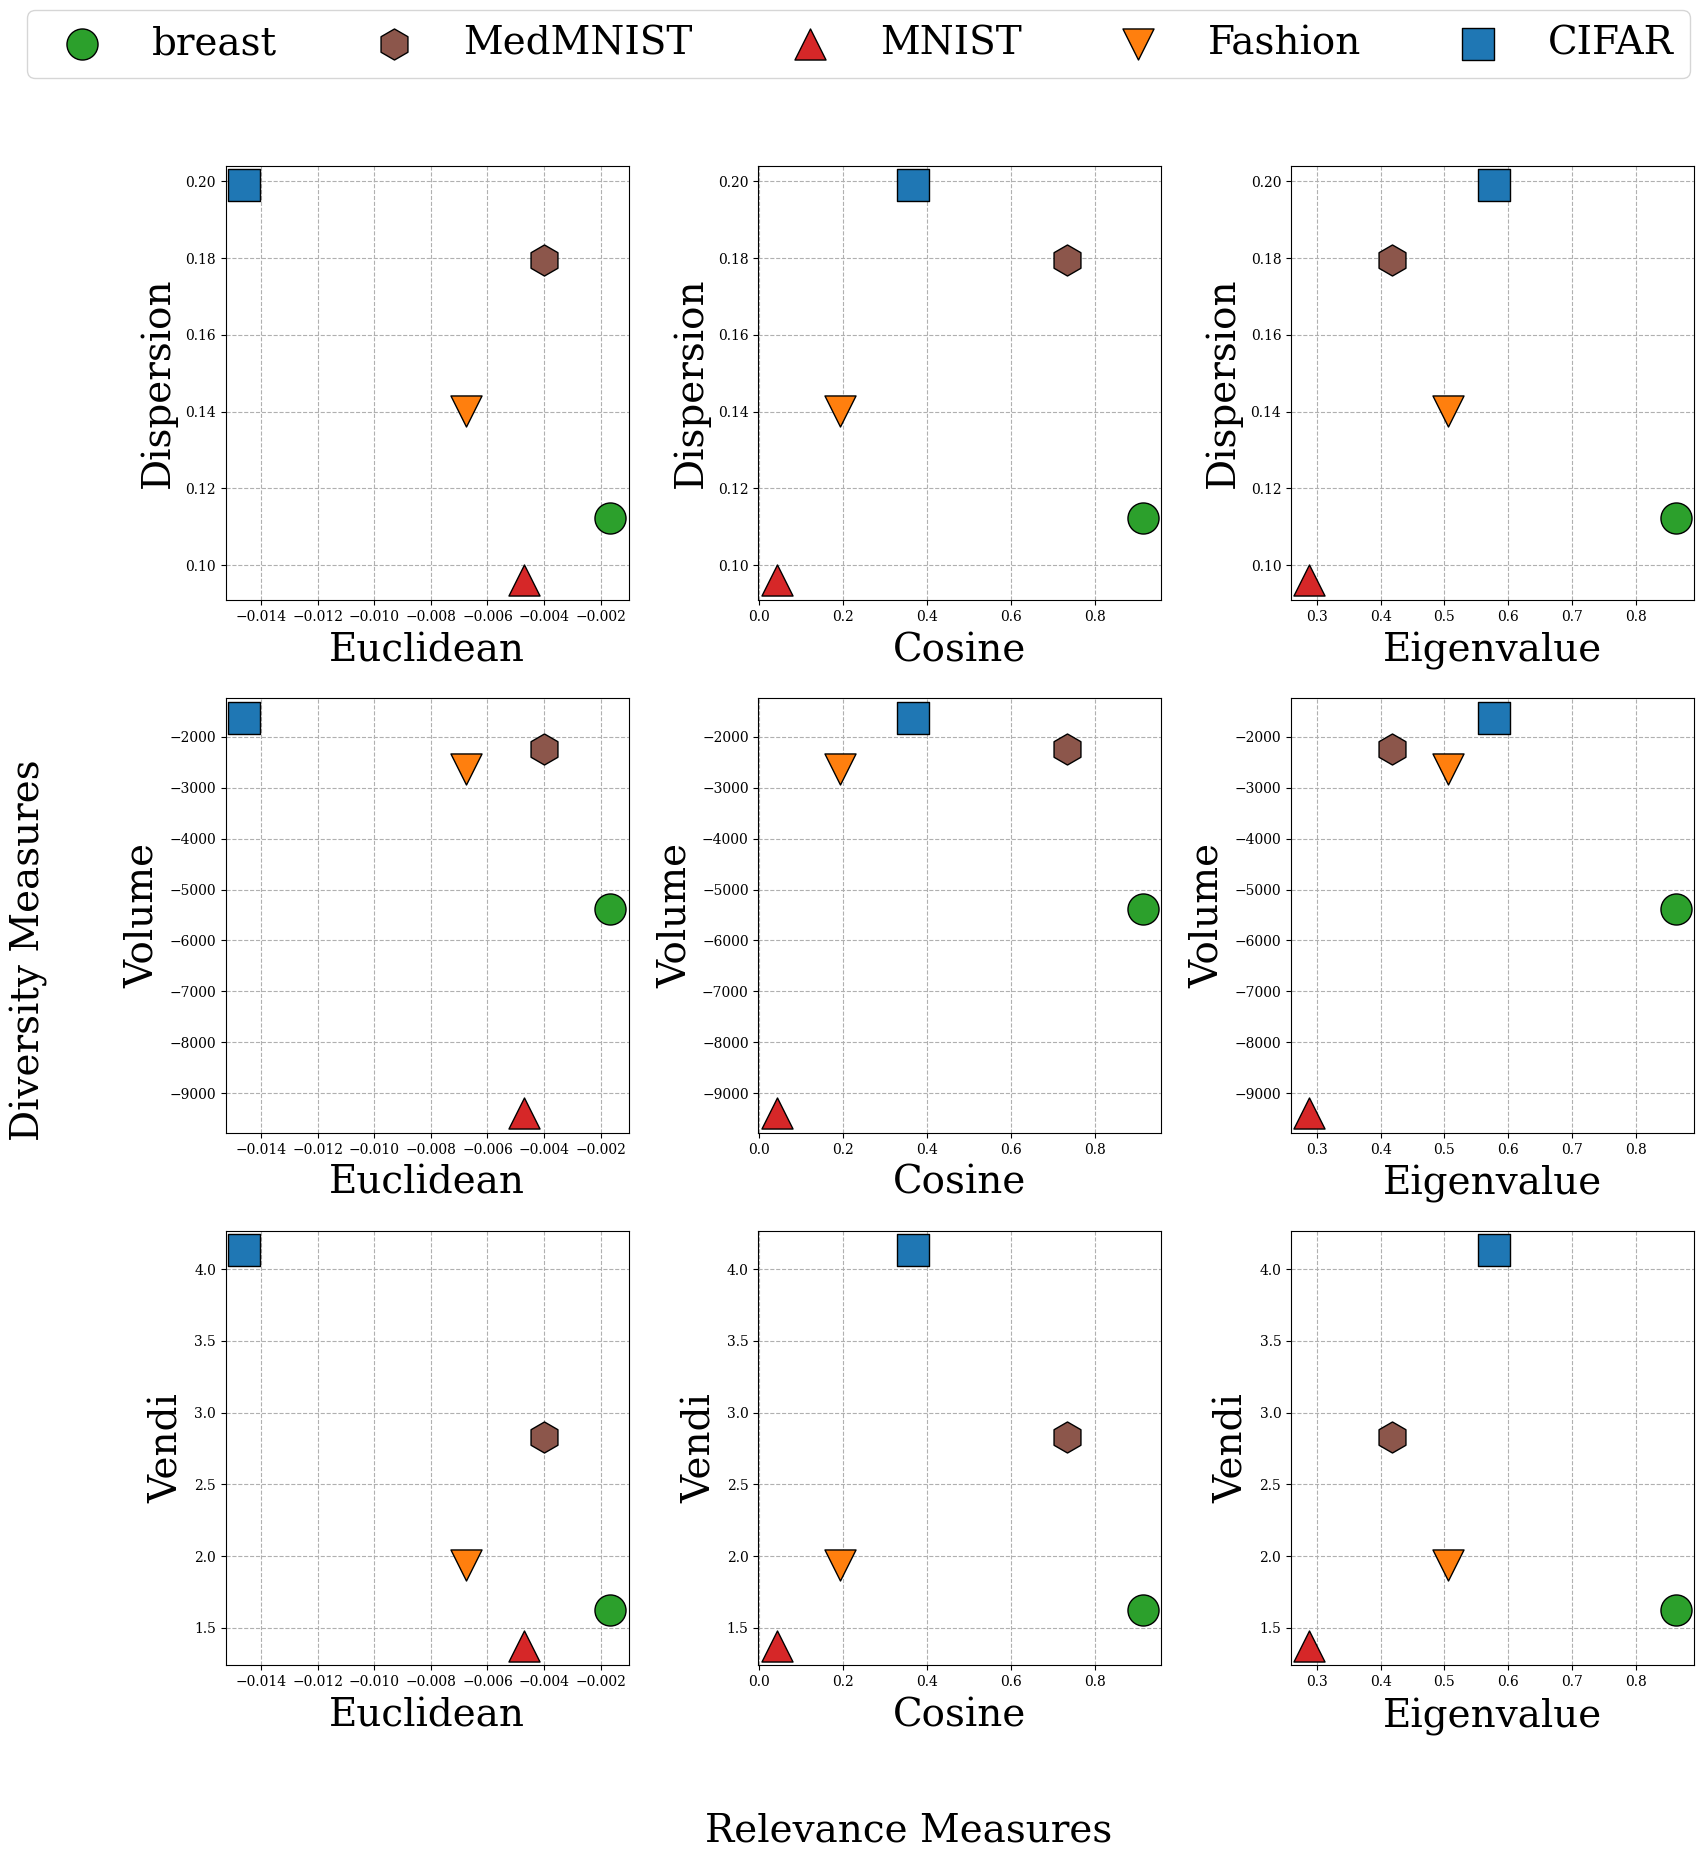

In [119]:
cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
s = 500

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, (k, v) in enumerate(seller_values.items()):
    
    if k == "CIFAR":
        c = "C0"
        marker = 's'
    elif k == "MNIST":
        c = "C3"
        marker = '^'
    elif k == "MedMNIST":
        c = "C5"
        marker = 'h'
    elif k == "Fashion":
        c = "C1"
        marker = 'v'
    else:
        # c = colors[i]
        c = 'C2'
        marker = 'o'

    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)

    axs[0, 0].scatter(v["l2"], v["dispersion"],  label=k, **scatter_kwargs)
    axs[1, 0].scatter(v["l2"], v["volume"], **scatter_kwargs)
    axs[2, 0].scatter(v["l2"], v["vendi"], **scatter_kwargs)
    axs[0, 1].scatter(v["cosine"], v["dispersion"],  **scatter_kwargs)
    axs[1, 1].scatter(v["cosine"], v["volume"], **scatter_kwargs)
    axs[2, 1].scatter(v["cosine"], v["vendi"], **scatter_kwargs)
    axs[0, 2].scatter(v["relevance"], v["dispersion"], **scatter_kwargs)
    axs[1, 2].scatter(v["relevance"], v["volume"], **scatter_kwargs)
    axs[2, 2].scatter(v["relevance"], v["vendi"], **scatter_kwargs)

axs[0, 0].set_xlabel("Euclidean", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("Euclidean", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("Euclidean", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
# ax[0].tick_params(axis="both", which="major", pad=10)
fig.text(0.5, -0.05, 'Relevance Measures', ha='center', va='center', fontsize=fontsize)
fig.text(-0.05, 0.5, 'Diversity Measures', ha='center', va='center', fontsize=fontsize, rotation=90)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=10)
    ax.grid(ls='--', zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

fig.legend(bbox_to_anchor=(1, 1.10), fontsize=fontsize, ncols=5)
fig.tight_layout(h_pad=2, w_pad=2)
plt.savefig(fig_dir / "relevance.eps", bbox_inches='tight')

### Measure relative diversity

tensor([0, 1, 2, 3, 4]) tensor([0, 1, 2, 3, 4])


<BarContainer object of 5 artists>

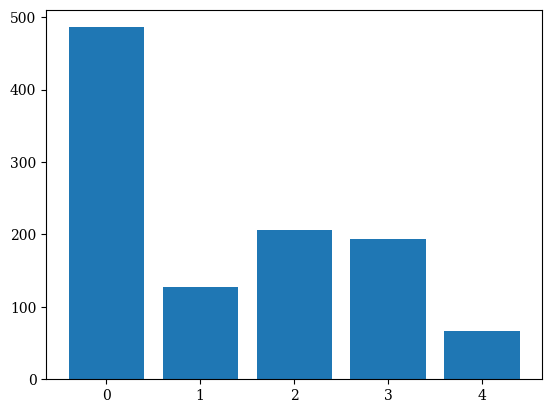

In [226]:
buyer_name = 'derma'
buyer_name = 'blood'
buyer_name = 'path' # decreases?
buyer_name = 'breast'
buyer_name = 'retina'
buyer = datasets[buyer_name]

# sort labels by descending frequency to account for class imbalance
# labels = torch.bincount(buyer["labels"].flatten()).argsort(descending=True)
labels = torch.unique(buyer["labels"])
# buyer_labels = labels[: len(labels) // 3 + 1]
buyer_labels = labels
# buyer_labels = labels[0]
print(buyer_labels, labels)

num_buyer = 100
num_seller = 1000

buyer_data = buyer["embeddings"][torch.isin(buyer["labels"], buyer_labels).flatten()][
    -num_buyer:
]

sellers = {
    f"{i + 1}": buyer["embeddings"][
        torch.isin(buyer["labels"], labels[: i + 1]).flatten()
    ][:num_seller]
    for i, j in enumerate(labels)
}

# sellers = {
#     f'{i}-{i+4}':buyer["embeddings"][torch.isin(buyer["labels"], labels[i:i+4]).flatten()][:num_seller]
#     for i, j in enumerate(labels[:-4])
# }

plt.bar(labels, torch.bincount(buyer["labels"].flatten()))

# sellers["MedMNIST"] = datasets['medmnist']["embeddings"][:num_seller]
# sellers["MNIST"] = datasets['mnist']["embeddings"][:num_seller]
# sellers["Fashion"] = datasets['fashion']["embeddings"][:num_seller]
# sellers["CIFAR"] = datasets['cifar']["embeddings"][:num_seller]

In [227]:
seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        norm_volume=True,
        use_rbf_kernel=True,
    )
    for k, v in tqdm(sellers.items())
}

  0%|          | 0/5 [00:00<?, ?it/s]

In [230]:
from scipy.stats import gmean
for k, v in sellers.items():
    print(gmean(np.std(v.numpy(), axis=0)))

0.10394
0.1079
0.1092
0.11066
0.11066


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


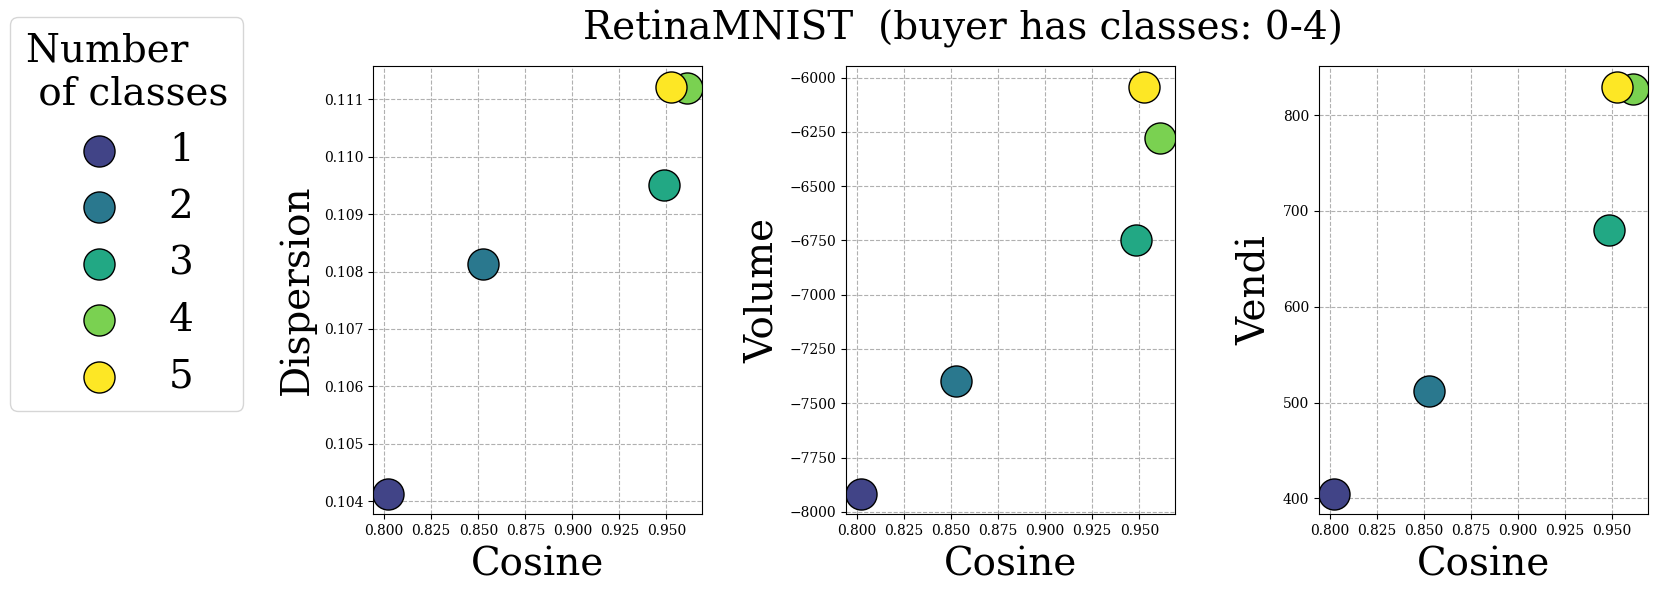

In [231]:
cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
s = 500

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

for i, (k, v) in enumerate(seller_values.items()):
    c = colors[i]
    marker = 'o'

    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)

    axs[0].scatter(v["cosine"], v["dispersion"], label=k, **scatter_kwargs)
    axs[1].scatter(v["cosine"], v["volume"], **scatter_kwargs)
    axs[2].scatter(v["cosine"], v["vendi"], **scatter_kwargs)

axs[0].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
# ax[0].tick_params(axis="both", which="major", pad=10)
# fig.text(0.5, -0.05, 'Relevance Measures', ha='center', va='center', fontsize=fontsize)
# fig.text(-0.05, 0.5, 'Diversity Measures', ha='center', va='center', fontsize=fontsize, rotation=90)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=10)
    ax.grid(ls='--', zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

fig.suptitle(f'{buyer_name.capitalize()}MNIST  (buyer has classes: {buyer_labels[0]}-{buyer_labels[-1]})', fontsize=fontsize)
fig.legend(bbox_to_anchor=(0, 1.00), fontsize=fontsize, ncols=1, title='Number \n of classes', title_fontsize=fontsize)
fig.tight_layout(h_pad=2, w_pad=3)
plt.savefig(fig_dir / "class-diversity.eps", bbox_inches='tight')

#### Old 

0.09999999999999999


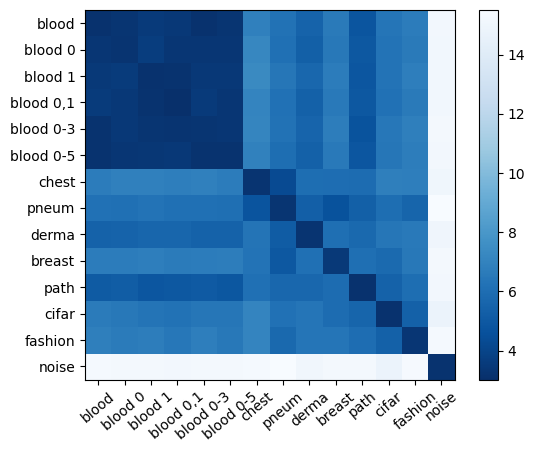

In [12]:
datasets = {
    "blood": blood["embeddings"],
    "blood 0": blood["embeddings"][(blood["labels"] == 0).squeeze()],
    "blood 1": blood["embeddings"][(blood["labels"] == 1).squeeze()],
    "blood 0,1": blood["embeddings"][
        torch.isin(blood["labels"], torch.tensor([0, 1])).squeeze()
    ],
    "blood 0-3": blood["embeddings"][
        torch.isin(blood["labels"], torch.tensor(list(range(4)))).squeeze()
    ],
    "blood 0-5": blood["embeddings"][
        torch.isin(blood["labels"], torch.tensor(list(range(8)))).squeeze()
    ],
    "chest": chest["embeddings"],
    "pneum": pneum["embeddings"],
    "derma": derma["embeddings"],
    "breast": breast["embeddings"],
    "path": path["embeddings"],
    "cifar": cifar["images"],
    "fashion": fashion["images"],
    "noise": np.random.uniform(size=(1000, 512)),
}

# num samples
N = 100

# random projections to D dimensions
# D = 100
# M = 1000
# gauss_proj = random_projection.GaussianRandomProjection(n_components=D)
# datasets = {k: gauss_proj.fit_transform(v[:M]) for k, v in datasets.items()}

# D = 100
# M = 1000
# pca = PCA(n_components=D)
# datasets = {k: pca.fit_transform(v[:M]) for k, v in datasets.items()}

mean_vec_a = [np.mean(np.array(x[:N]), 0) for x in datasets.values()]
mean_vec_b = [np.mean(np.array(x[N : 2 * N]), 0) for x in datasets.values()]

# add noise
eps = 0.1  # privacy budget
scale = 1 / N / eps
print(scale)
mean_vec_a = [x + np.random.normal(0, scale, size=x.shape[0]) for x in mean_vec_a]
mean_vec_b = [x + np.random.normal(0, scale, size=x.shape[0]) for x in mean_vec_b]


dist = DistanceMetric.get_metric("euclidean")
plt.imshow(dist.pairwise(mean_vec_a, mean_vec_b), cmap="Blues_r")
plt.colorbar()
plt.xticks(range(len(datasets)), labels=datasets.keys(), rotation=40)
plt.yticks(range(len(datasets)), labels=datasets.keys(), rotation=0)
plt.show()

In [13]:
k(blood["embeddings"][0].numpy(), blood["embeddings"][1].numpy())

NameError: name 'k' is not defined

In [17]:
vendi.score_dual(blood["embeddings"][:n].numpy(), normalize=True)

1.7493303

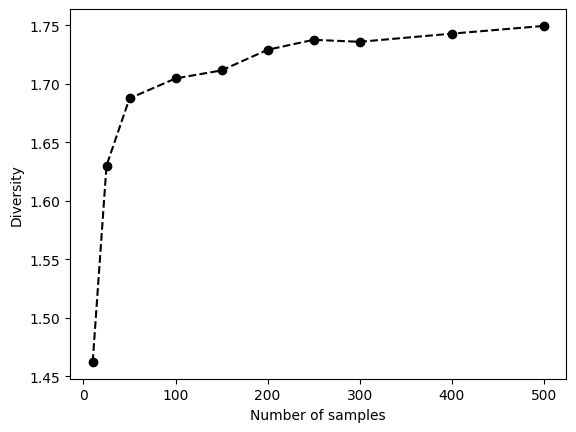

In [14]:
from vendi_score import vendi

k = lambda a, b: np.mean(np.exp(-np.abs(a - b)))

ns = [10, 25, 50, 100, 150, 200, 250, 300, 400, 500]
vs = []
for n in ns:
    # vs.append(vendi.score(blood['embeddings'][:n].numpy(), k))
    vs.append(vendi.score_dual(blood["embeddings"][:n].numpy(), normalize=True))


plt.xlabel("Number of samples")
plt.ylabel("Diversity")
plt.plot(ns, vs, "o--k")

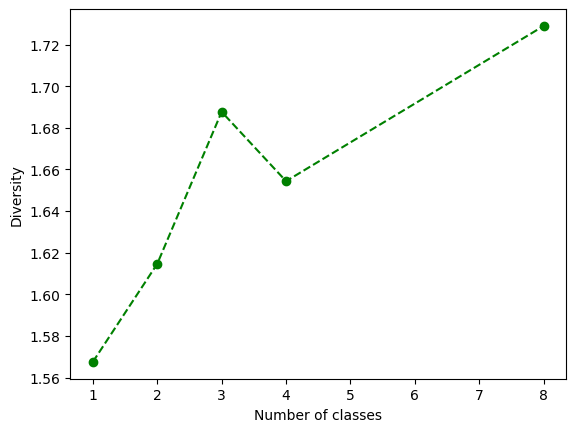

In [15]:
cs = {
    1: blood["embeddings"][torch.isin(blood["labels"], torch.tensor([0])).squeeze()][
        :200
    ],
    2: blood["embeddings"][torch.isin(blood["labels"], torch.tensor([0, 1])).squeeze()][
        :200
    ],
    3: blood["embeddings"][
        torch.isin(blood["labels"], torch.tensor([0, 1, 2])).squeeze()
    ][:200],
    4: blood["embeddings"][
        torch.isin(blood["labels"], torch.tensor([0, 1, 2, 3])).squeeze()
    ][:200],
    8: blood["embeddings"][
        torch.isin(blood["labels"], torch.tensor([0, 1, 2, 3, 4, 5, 6, 7])).squeeze()
    ][:200],
}
class_vs = []
for c in cs.values():
    # class_vs.append(vendi.score(c.numpy(), k))
    class_vs.append(vendi.score_dual(c.numpy(), normalize=True))


plt.xlabel("Number of classes")
plt.ylabel("Diversity")
plt.plot(cs.keys(), class_vs, "o--g")

In [ ]:
print(euclid_dis(blood["embeddings"][:100].numpy(), derma["embeddings"][:100].numpy()))
print(
    euclid_dis(blood["embeddings"][:100].numpy(), blood["embeddings"][100:200].numpy())
)
print(euclid_dis(blood["embeddings"][:100].numpy(), derma["embeddings"][:100].numpy()))
print(
    euclid_dis(blood["embeddings"][:100].numpy(), blood["embeddings"][100:200].numpy())
)

In [363]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def calculate_normalized_knn_density(X, k):
    """
    Calculate the normalized KNN density for each point in the dataset.

    Parameters:
    X (array-like): Dataset of shape (n_samples, n_features)
    k (int): Number of neighbors to consider for KNN

    Returns:
    numpy.ndarray: Array of normalized density values
    """
    # Create a NearestNeighbors instance and fit it to the data
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)

    # Find the distances to the k-th nearest neighbors for each point
    distances, _ = neigh.kneighbors(X)
    kth_distances = distances[:, -1]

    # # Estimate density (number of points divided by the volume of the hypersphere)
    # # Volume of a hypersphere: V = (π^(n/2) / Γ(n/2 + 1)) * r^n
    # # Where n is the number of dimensions and r is the radius (k-th distance)
    # n_dimensions = X.shape[1]
    # volume = (np.pi ** (n_dimensions / 2) / np.math.gamma(n_dimensions / 2 + 1)) * (kth_distances ** n_dimensions)
    # density = k / volume

    # # Normalize the density values to range [0, 1]
    # min_density, max_density = np.min(density), np.max(density)
    # normalized_density = (density - min_density) / (max_density - min_density)
    # return normalized_density

    # Estimate density using a simpler volume approximation for high dimensions
    # Use logarithms to calculate volume for high dimensions to avoid overflow
    n_dimensions = X.shape[1]
    log_volume = n_dimensions * np.log(2 * kth_distances)
    # Density is proportional to 1/volume, so we can use -log(volume) for comparison
    log_density = -log_volume

    # Normalize the log density values to range [0, 1]
    # min_log_density, max_log_density = np.min(log_density), np.max(log_density)
    # normalized_log_density = (log_density - min_log_density) / (max_log_density - min_log_density)
    return log_density


import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


def calculate_normalized_knn_density_cosine_similarity(X, k):
    """
    Calculate the normalized KNN density for each point in the dataset, using average cosine similarity
    between each point and its k nearest neighbors as a measure of density.

    Parameters:
    X (array-like): Dataset of shape (n_samples, n_features)
    k (int): Number of neighbors to consider for KNN

    Returns:
    numpy.ndarray: Array of normalized density values based on cosine similarity
    """
    # Create a NearestNeighbors instance and fit it to the data
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)

    # Find the k nearest neighbors for each point (excluding the point itself)
    _, indices = neigh.kneighbors(X)
    indices = indices[:, 1:]  # exclude the first column as it is the point itself

    # Calculate average cosine similarity for each point with its k neighbors
    avg_cosine_similarities = np.array(
        [np.mean(cosine_similarity([X[i]], X[indices[i]])) for i in range(X.shape[0])]
    )
    return avg_cosine_similarities

    # Normalize the cosine similarity values to range [0, 1]
    # min_similarity, max_similarity = np.min(avg_cosine_similarities), np.max(avg_cosine_similarities)
    # normalized_similarity = (avg_cosine_similarities - min_similarity) / (max_similarity - min_similarity)
    # return normalized_similarity

In [401]:
cosine_similarity(blood["embeddings"][:100])[0] > 0.95

array([ True, False, False, False,  True, False, False, False,  True,
        True, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False])

In [412]:
np.isin(blood["labels"], [0, 1])

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<BarContainer object of 8 artists>

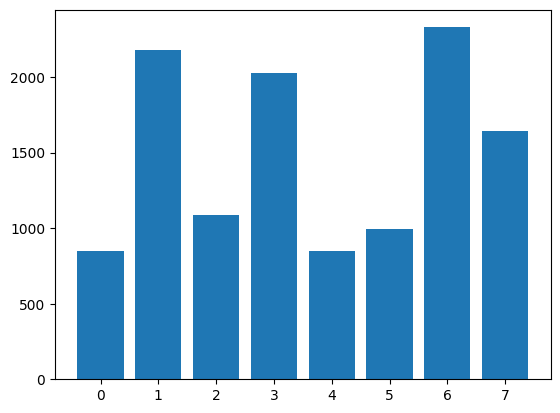

In [428]:
plt.bar(range(8), blood["labels"].squeeze().bincount())

In [441]:
cosine_similarity(
    np.concatenate(
        [
            # blood['embeddings'].mean(0, keepdims=True),
            blood["embeddings"][np.isin(blood["labels"], [0]).squeeze()].mean(
                0, keepdims=True
            ),
            blood["embeddings"][np.isin(blood["labels"], [1]).squeeze()].mean(
                0, keepdims=True
            ),
            blood["embeddings"][np.isin(blood["labels"], [2]).squeeze()].mean(
                0, keepdims=True
            ),
            blood["embeddings"][np.isin(blood["labels"], [3]).squeeze()].mean(
                0, keepdims=True
            ),
            blood["embeddings"][np.isin(blood["labels"], [4]).squeeze()].mean(
                0, keepdims=True
            ),
            blood["embeddings"][np.isin(blood["labels"], [5]).squeeze()].mean(
                0, keepdims=True
            ),
            blood["embeddings"][np.isin(blood["labels"], [6]).squeeze()].mean(
                0, keepdims=True
            ),
        ]
    )
)

array([[1.        , 0.99053153, 0.98499237, 0.99767902, 0.99337538,
        0.99459199, 0.9872964 ],
       [0.99053153, 1.        , 0.98095722, 0.98885804, 0.98749448,
        0.98701771, 0.98107277],
       [0.98499237, 0.98095722, 1.        , 0.98887894, 0.99476496,
        0.98147922, 0.98597513],
       [0.99767902, 0.98885804, 0.98887894, 1.        , 0.99480312,
        0.99562307, 0.99067591],
       [0.99337538, 0.98749448, 0.99476496, 0.99480312, 1.        ,
        0.98859229, 0.99161509],
       [0.99459199, 0.98701771, 0.98147922, 0.99562307, 0.98859229,
        1.        , 0.98327843],
       [0.9872964 , 0.98107277, 0.98597513, 0.99067591, 0.99161509,
        0.98327843, 1.        ]])

In [18]:
from scipy.stats import entropy

f = lambda x: np.mean((x > 0.90).sum(0))

print(
    f(
        cosine_similarity(
            blood["embeddings"][np.isin(blood["labels"], [0]).squeeze()][:100]
        )
    )
)
print(
    f(
        cosine_similarity(
            blood["embeddings"][np.isin(blood["labels"], [0, 1, 2]).squeeze()][:100]
        )
    )
)
print(
    f(
        cosine_similarity(
            blood["embeddings"][np.isin(blood["labels"], [0, 1, 2, 3]).squeeze()][:100]
        )
    )
)
print(
    f(
        cosine_similarity(
            blood["embeddings"][np.isin(blood["labels"], [0, 1, 2, 3, 4, 5]).squeeze()][
                :100
            ]
        )
    )
)
print(f(cosine_similarity(blood["embeddings"][:100])))

print(
    f(
        cosine_similarity(
            np.concatenate([blood["embeddings"][:50], breast["embeddings"][:50]])
        )
    )
)

print(
    f(
        cosine_similarity(
            np.concatenate(
                [
                    blood["embeddings"][:33],
                    breast["embeddings"][:33],
                    derma["embeddings"][:33],
                ]
            )
        )
    )
)

NameError: name 'cosine_similarity' is not defined

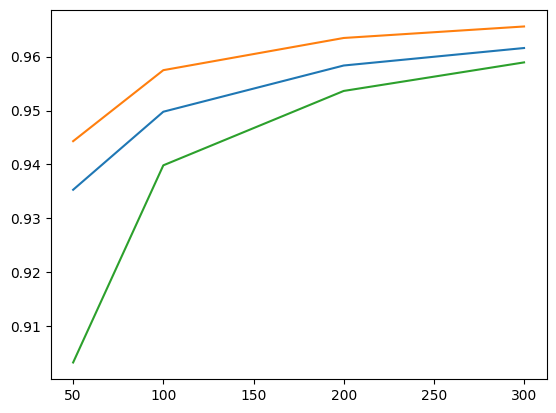

In [368]:
# xs = [10, 50, 100, 200, 300, 500, 750, 1000]
xs = [50, 100, 200, 300]
K = 30
# plt.plot(xs, [calculate_normalized_knn_density(blood['embeddings'][:x], 10).mean() for x in xs])
# plt.plot(xs, [calculate_normalized_knn_density(breast['embeddings'][:x], 10).mean() for x in xs])
# plt.plot(xs, [calculate_normalized_knn_density(np.concatenate([blood['embeddings'][:x//2],
#                                                                breast['embeddings'][:x//2]]), 10).mean() for x in xs])
plt.plot(
    xs,
    [
        calculate_normalized_knn_density_cosine_similarity(
            blood["embeddings"][:x], k=K
        ).mean()
        for x in xs
    ],
)
plt.plot(
    xs,
    [
        calculate_normalized_knn_density_cosine_similarity(
            breast["embeddings"][:x], k=K
        ).mean()
        for x in xs
    ],
)
plt.plot(
    xs,
    [
        calculate_normalized_knn_density_cosine_similarity(
            np.concatenate(
                [blood["embeddings"][: x // 2], breast["embeddings"][: x // 2]]
            ),
            k=K,
        ).mean()
        for x in xs
    ],
)

In [21]:
n_sell = 1000
n_components = 10
buyer = breast["embeddings"][-100:]
derma_values = valuation.get_value(
    buyer, derma["embeddings"][:n_sell], n_components=n_components
)
chest_values = valuation.get_value(
    buyer, chest["embeddings"][:n_sell], n_components=n_components
)
path_values = valuation.get_value(
    buyer, path["embeddings"][:n_sell], n_components=n_components
)
breast_values = valuation.get_value(
    buyer, breast["embeddings"][:n_sell], n_components=n_components
)
pneum_values = valuation.get_value(
    buyer, pneum["embeddings"][:n_sell], n_components=n_components
)
cifar_values = valuation.get_value(
    buyer, cifar["images"][:n_sell], n_components=n_components
)
fashion_values = valuation.get_value(
    buyer, fashion["images"][:n_sell], n_components=n_components
)
noise_values = valuation.get_value(
    buyer, np.random.uniform(size=(n_sell, 512)), n_components=n_components
)

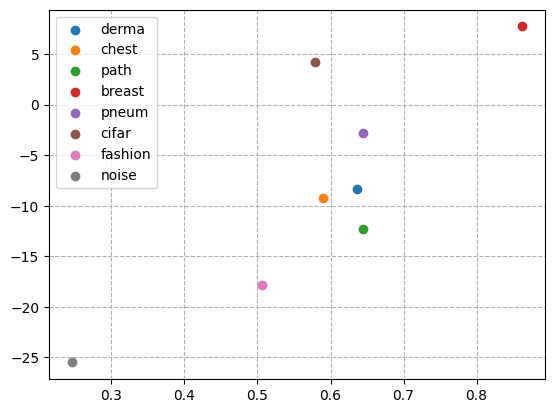

In [22]:
plt.scatter(derma_values["relevance"], derma_values["volume"], label="derma")
plt.scatter(chest_values["relevance"], chest_values["volume"], label="chest")
plt.scatter(path_values["relevance"], path_values["volume"], label="path")
plt.scatter(breast_values["relevance"], breast_values["volume"], label="breast")
plt.scatter(pneum_values["relevance"], pneum_values["volume"], label="pneum")
plt.scatter(cifar_values["relevance"], cifar_values["volume"], label="cifar")
plt.scatter(fashion_values["relevance"], fashion_values["volume"], label="fashion")
plt.scatter(noise_values["relevance"], noise_values["volume"], label="noise")
plt.legend()
plt.grid(ls="--")

In [ ]:
def class_subset(x):
    emb = x["embeddings"]
    lab = x["labels"]

In [67]:
pneum["embeddings"].shape

torch.Size([4708, 512])

In [64]:
num_buyer = 5000
buyer = chest["embeddings"][:num_buyer]

chest_values = {}
chest_values[100] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 200], n_components=5
)
chest_values[200] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 300], n_components=5
)
chest_values[300] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 400], n_components=5
)
chest_values[400] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 500], n_components=5
)
chest_values[500] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 600], n_components=5
)
chest_values[600] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 700], n_components=5
)
chest_values[700] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 800], n_components=5
)
chest_values[1000] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 1000], n_components=5
)
chest_values[2000] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 2000], n_components=5
)
chest_values[3000] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 3000], n_components=5
)
chest_values[4000] = valuation.get_value(
    buyer, chest["embeddings"][num_buyer : num_buyer + 4000], n_components=5
)

pneum_values = {}
pneum_values[100] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 200], n_components=5
)
pneum_values[200] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 300], n_components=5
)
pneum_values[300] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 400], n_components=5
)
pneum_values[400] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 500], n_components=5
)
pneum_values[500] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 600], n_components=5
)
pneum_values[600] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 700], n_components=5
)
pneum_values[700] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 800], n_components=5
)
pneum_values[1000] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 1000], n_components=5
)
pneum_values[2000] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 2000], n_components=5
)
pneum_values[3000] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 3000], n_components=5
)
pneum_values[4000] = valuation.get_value(
    buyer, pneum["embeddings"][num_buyer : num_buyer + 4000], n_components=5
)

blood_values = {}
blood_values[100] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 200], n_components=5
)
blood_values[200] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 300], n_components=5
)
blood_values[300] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 400], n_components=5
)
blood_values[400] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 500], n_components=5
)
blood_values[500] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 600], n_components=5
)
blood_values[600] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 700], n_components=5
)
blood_values[700] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 800], n_components=5
)
blood_values[1000] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 1000], n_components=5
)
blood_values[2000] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 2000], n_components=5
)
blood_values[3000] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 3000], n_components=5
)
blood_values[4000] = valuation.get_value(
    buyer, blood["embeddings"][num_buyer : num_buyer + 4000], n_components=5
)

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/u/luchar/data-valuation/valuation.py:153: RuntimeWarning: Degrees of freedom <= 0 for slice
  seller_cov = np.cov(seller_data, rowvar=False)
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: Found array with 0 sample(s) (shape=(0, 512)) while a minimum of 1 is required by Normalizer.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(chest_values.keys(), [x["volume"] for x in chest_values.values()], lw=3)
plt.plot(pneum_values.keys(), [x["volume"] for x in pneum_values.values()], lw=3)
plt.plot(blood_values.keys(), [x["volume"] for x in blood_values.values()], lw=3)
plt.xlabel("Samples")
plt.ylabel("Volume")

Text(0, 0.5, 'relevance')

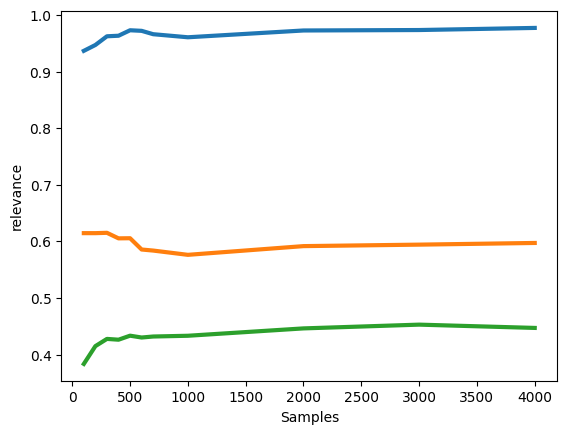

In [62]:
plt.plot(chest_values.keys(), [x["relevance"] for x in chest_values.values()], lw=3)
plt.plot(pneum_values.keys(), [x["relevance"] for x in pneum_values.values()], lw=3)
plt.plot(blood_values.keys(), [x["relevance"] for x in blood_values.values()], lw=3)
plt.xlabel("Samples")
plt.ylabel("relevance")

Text(0, 0.5, 'diversity')

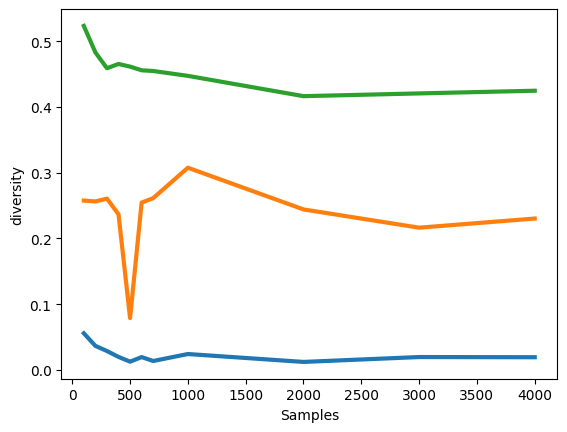

In [63]:
plt.plot(chest_values.keys(), [x["diversity"] for x in chest_values.values()], lw=3)
plt.plot(pneum_values.keys(), [x["diversity"] for x in pneum_values.values()], lw=3)
plt.plot(blood_values.keys(), [x["diversity"] for x in blood_values.values()], lw=3)
plt.xlabel("Samples")
plt.ylabel("diversity")

In [86]:
n_components = 5
seller = chest["embeddings"][-1000:]
chest_values = {}
chest_values[10] = valuation.get_value(
    chest["embeddings"][:10], seller, n_components=n_components
)
chest_values[50] = valuation.get_value(
    chest["embeddings"][:50], seller, n_components=n_components
)
chest_values[100] = valuation.get_value(
    chest["embeddings"][:100], seller, n_components=n_components
)
chest_values[1000] = valuation.get_value(
    chest["embeddings"][:1000], seller, n_components=n_components
)
chest_values[2000] = valuation.get_value(
    chest["embeddings"][:2000], seller, n_components=n_components
)
chest_values[3000] = valuation.get_value(
    chest["embeddings"][:3000], seller, n_components=n_components
)
chest_values[4000] = valuation.get_value(
    chest["embeddings"][:4000], seller, n_components=n_components
)
chest_values[5000] = valuation.get_value(
    chest["embeddings"][:5000], seller, n_components=n_components
)
chest_values[10000] = valuation.get_value(
    chest["embeddings"][:10000], seller, n_components=n_components
)

In [87]:
chest_values

{10: {'diversity': 0.3470494121091618,
  'relevance': 0.477678252607615,
  'volume': 3.22084288853422},
 50: {'diversity': 0.1694284978460775,
  'relevance': 0.7852568293612006,
  'volume': 8.163140011726002},
 100: {'diversity': 0.13658833965409686,
  'relevance': 0.8445761968910557,
  'volume': 8.146887971845167},
 1000: {'diversity': 0.011312604476953252,
  'relevance': 0.9736378398846057,
  'volume': 9.13827466832982},
 2000: {'diversity': 0.01532100398294375,
  'relevance': 0.9764298560623303,
  'volume': 8.904489589727818},
 3000: {'diversity': 0.015069607062997745,
  'relevance': 0.9801044265135145,
  'volume': 9.100816952592675},
 4000: {'diversity': 0.02268934597722707,
  'relevance': 0.9736703702559314,
  'volume': 9.11164104810131},
 5000: {'diversity': 0.018689691935302427,
  'relevance': 0.9730832404488897,
  'volume': 9.01996217079575},
 10000: {'diversity': 0.007375132724674479,
  'relevance': 0.9845594136582385,
  'volume': 9.048700961056978}}

(0.0, 10.0)

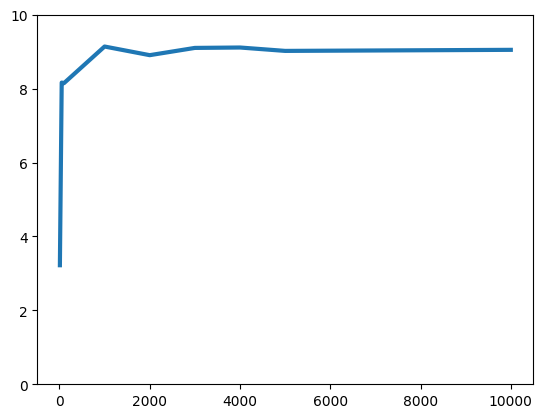

In [88]:
plt.plot(chest_values.keys(), [x["volume"] for x in chest_values.values()], lw=3)
plt.ylim(0, 10)

In [18]:
torch.bincount(chest["labels"].argmax(1))

tensor([50401,  1686,  6445,  9483,  2313,  2292,   307,  1935,  1060,   503,
          676,   535,   761,    71])

In [9]:
buyer_chest = chest["embeddings"]

tensor([[ 0.2622, -0.3220,  0.4648,  ...,  0.0489, -0.1783,  0.2825],
        [ 0.5317, -0.4106,  0.3445,  ..., -0.0377, -0.3228,  0.0063],
        [ 0.5298, -0.3950,  0.3970,  ..., -0.0118, -0.2291,  0.1998],
        ...,
        [ 0.5933, -0.3064,  0.3423,  ...,  0.0922, -0.2076,  0.2791],
        [ 0.4268, -0.4851,  0.2253,  ..., -0.0913, -0.2620,  0.1611],
        [ 0.4673, -0.4021,  0.6216,  ..., -0.0330,  0.1606, -0.0870]],
       dtype=torch.float16)

In [7]:
values = {}
threshold = 0.1
n_components = 10
omega = 0.1
norm_volume = True
kwargs = dict(
    threshold=threshold,
    n_components=n_components,
    omega=omega,
    norm_volume=norm_volume,
)
values["buyer"] = get_value(buyer_data, buyer_data, **kwargs)

NameError: name 'collections' is not defined